# Evaluate Age and Gender VGGFace Models on Juul Faces

### Imports

In [1]:
import torch
import pickle
import sys, os

import importlib

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_dir = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
if not project_dir in sys.path: sys.path.append(project_dir)

In [3]:
train_utils = importlib.import_module('src.age_gender.train_utils', project_dir)
plot = importlib.import_module('src.rgutils.plot', project_dir)
utils = importlib.import_module('src.utils', project_dir)

In [4]:
%load_ext autoreload

%autoreload 2

In [5]:
device = torch.device('cuda')

In [26]:
# %load ../src/age_gender/inference_utils.py
from torch.utils.data import Dataset
import numpy as np
import torch
from tqdm import tqdm
from collections import Counter
import os,sys
import importlib
# custom modules
project_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath(__name__))))
if project_dir not in sys.path: sys.path.insert(0, project_dir)
train_utils = importlib.import_module('src.age_gender.train_utils', project_dir)
utils = importlib.import_module('src.utils', project_dir)


age_vals =  ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', 
            '(38, 43)', '(48, 53)', '(60, 100)']
gender_vals = ['f', 'm']
base_age_mapping = {'(0, 2)':'0-17', '(4, 6)':'0-17', '(8, 13)':'0-17',
                    '(15, 20)':'18-25', '(25, 32)':'25-35', '(38, 43)':'35-45',
                    '(48, 53)':'45-60', '(60, 100)':'60+'}


def load_cv_models(backbone_model, model_path, indices, num_classes, device, 
                   print_results=False):
    '''
    Load cross-validated models from disk and create models for inference.
    Params:
        backbone_model - loaded vgg model
        model_path - path to a cv model with '{index}' inside
        indices - list of cv indices
        num_classes - 8 for age and 1 for gender
    Returns a dict in the format {cv_index: model}
    '''
    cv_models = {}
    for i in indices:
        path = model_path.format(index = i)
        net = train_utils.create_model(backbone_model, num_classes, device,)
        net.load_state_dict(torch.load(path))
        net.eval()
        cv_models[i] = net
        if print_results:
            print(f'{device.type}:{device.index}: Loaded {path}')
    return cv_models


class FaceDataset(Dataset):
    '''
    Use this dataset class at inference
    Params:
        face_detections: path to hdf5 file with detections from face_detector.py
        face_clusters: path to npy file with assigned cluster from cluster_faces.py
        model_input_size: resize images for model input, used (224,224)
        input_transforms: torch transforms as traing
    '''
    def __init__(self, face_detections, face_clusters, model_input_size,
                 input_transforms=None, print_results=False):
        image_paths = utils.load_hdf(face_detections, keys=['image_paths'], 
                                     print_results=print_results)['image_paths']
        clusters = np.load(face_clusters)
        assert len(image_paths) == len(clusters)
        # select only clustered images
        self.image_paths = image_paths[clusters > 0]
        self.image_paths = [p.decode('utf-8') for p in self.image_paths]
        self.clusters = clusters[clusters > 0]
        self.model_input_size = model_input_size
        self.input_transforms = input_transforms
        if print_results:
            print(f'{self.__len__()} face images in the dataset')
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = train_utils.load_convert_resize(image_path, self.model_input_size)
        if self.input_transforms:
            img = self.input_transforms(img)
        return img, _


def batch_cv_predictions(age_cv, gender_cv, face_loader, device, 
                         gender_threshold=0.5):
    '''
    Make batch predictions for faces both age and gender
    Params:
        age_cv: dict of cv age models
        gender_cv: dict of cv gender models
        face_loader: dataloader for faces
        gender_threshold: 0.5 default where 1 - male, 0 - female
    Returns two numpy arrays for age and gender predictions,
    each one of size (len(dataset), len(cv_models))
    '''
    dataset_len = len(face_loader.dataset)
    age_predictions = torch.zeros(dataset_len, len(age_cv), device=device)
    gender_predictions = torch.zeros(dataset_len, len(gender_cv), device=device)
    batch_num = 0
    with torch.no_grad():
        for x,y in tqdm(face_loader, desc='Batches'):
            start = batch_num * face_loader.batch_size
            end = min((batch_num + 1) * face_loader.batch_size, dataset_len)
            # predict ages
            for i,age_model in age_cv.items():
                age_out = age_model(x.to(device))
                _,y_pred_age = torch.max(age_out, dim=1)
                age_predictions[start:end, i] = y_pred_age
            # predict genders
            for i,gender_model in gender_cv.items():
                gender_out = gender_model(x.to(device))
                y_pred_gender = torch.sigmoid(torch.squeeze(gender_out, dim=1)) > gender_threshold
                gender_predictions[start:end, i] = y_pred_gender
            batch_num += 1
    return age_predictions, gender_predictions


# count predictions for age and gender
age_decoded = {v:k for v,k in enumerate(age_vals)}
gender_decoded = {v:k for v,k in enumerate(gender_vals)}
get_age_fn = lambda x: Counter([age_decoded[int_label] for int_label in list(x.cpu().numpy())])
get_gender_fn = lambda x: Counter([gender_decoded[int_label] for int_label in list(x.cpu().numpy())])


def transform_age(age_counter):
    '''
    Transform model age output to desired groups:
    0-17 18-25 25-35 35-45 45-60 60+
    Return a str age group
    '''
    if len(age_counter) == 1:
        key = list(age_counter.keys())[0]
        return base_age_mapping[key]
    elif len(age_counter) > 1:
        (top1_label,top1_cnt),(top2_label,top2_cnt) = age_counter.most_common(2)
        if top1_label != '(15, 20)':
            cnter = Counter({top1_label: top1_cnt})
        else:
            if top2_label in ['(0, 2)', '(4, 6)', '(8, 13)',]:
                cnter = Counter({top2_label: top1_cnt + top2_cnt})
            elif top2_label in ['(15, 20)', '(25, 32)', 
                                '(38, 43)', '(48, 53)', '(60, 100)']:
                cnter = Counter({top1_label: top1_cnt + top2_cnt})
            else:
                raise Exception(f'Invalid label: {top2_label} in {age_counter}')
        return transform_age(cnter)
    else:
        raise Exception(f'{age_counter} has len {len(age_counter)}')
        
        
def transform_gender(gender_counter):
    '''
    Return most frequent label from a counter
    '''
    lab,cnt = gender_counter.most_common(1)[0]
    return lab
        
        
def cluster_label_counter(labels):
    '''
    From an array of labels return a counter of labels
    '''
    label_counter = Counter()
    _ = [label_counter.update(mc) for mc in labels]
    return label_counter



In [8]:

def visalize_aggregated_cluster_prediction(n_row, n_col, image_clusters, image_paths, predicted_labels,
                                           individual_title = False, transform_age_label=False):
    fig,axes = plt.subplots(n_row, n_col, squeeze=False, figsize=(n_col*2, n_row*2))
    _ = [a.axis('off') for a in axes.ravel()]

    for r in range(n_row):
        clust = np.random.choice(np.unique(image_clusters))
        cluster_images = image_paths[image_clusters == clust]
        cluster_labels = predicted_labels[image_clusters == clust]
        num_show = min(n_col, len(cluster_images))
        indices = np.random.choice(len(cluster_images), size=num_show)
        for c,ind in enumerate(indices):
            img = plt.imread(cluster_images[ind])
            axes[r,c].imshow(img)
            if individual_title:
                mc = cluster_labels[ind].most_common()
                title = [f'{cnt}:{lab}' for lab,cnt in mc]
                title = ' | '.join(title)
                axes[r,c].set_title(title)
            else:
                if c == num_show // 2:
                    label_counter = cluster_label_counter(cluster_labels)
                    title = [f'{cnt}:{lab}' for lab,cnt in label_counter.most_common()]
                    title = ' | '.join(title)
                    if transform_age_label:
                        transformed = transform_age(label_counter)
                        title = f'{title} -> {transformed}'
                    axes[r,c].set_title(title)

    plt.show()

### Predict ages and gender

In [9]:
!ls -l ../models/age_gender/best

total 921296
-rw-rw-r-- 1 neuro neuro 94363915 Aug  8 11:41 vgg_age_cv0.hdf
-rw-rw-r-- 1 neuro neuro 94363959 Aug  8 11:41 vgg_age_cv1.hdf
-rw-rw-r-- 1 neuro neuro 94363927 Aug  8 11:41 vgg_age_cv2.hdf
-rw-rw-r-- 1 neuro neuro 94363927 Aug  8 11:41 vgg_age_cv3.hdf
-rw-rw-r-- 1 neuro neuro 94363919 Aug  8 11:41 vgg_age_cv4.hdf
-rw-rw-r-- 1 neuro neuro 94306539 Aug  8 11:41 vgg_gender_cv0.hdf
-rw-rw-r-- 1 neuro neuro 94306545 Aug  8 11:41 vgg_gender_cv1.hdf
-rw-rw-r-- 1 neuro neuro 94306567 Aug  8 11:41 vgg_gender_cv2.hdf
-rw-rw-r-- 1 neuro neuro 94306555 Aug  8 11:41 vgg_gender_cv3.hdf
-rw-rw-r-- 1 neuro neuro 94306543 Aug  8 11:41 vgg_gender_cv4.hdf


##### Load models

In [114]:
vggface_weights = '../models/external/resnet50_ft_weight.pkl'
age_model_path = '../models/age_gender/best/vgg_age_cv{index}.hdf'
gender_model_path = '../models/age_gender/best/vgg_gender_cv{index}.hdf'

num_folds = 5
age_classes = 8
gender_output_units = 1

In [113]:
vggface = train_utils.load_vggface_model('resnet', project_dir, vggface_weights)
vggface.cuda()
cv_indices = list(range(num_folds))

In [121]:
age_cv = load_cv_models(vggface, age_model_path, cv_indices, age_classes, device, True)

cuda:None: Loaded ../models/age_gender/best/vgg_age_cv0.hdf
cuda:None: Loaded ../models/age_gender/best/vgg_age_cv1.hdf
cuda:None: Loaded ../models/age_gender/best/vgg_age_cv2.hdf
cuda:None: Loaded ../models/age_gender/best/vgg_age_cv3.hdf
cuda:None: Loaded ../models/age_gender/best/vgg_age_cv4.hdf


In [123]:
gender_cv = load_cv_models(vggface, gender_model_path, cv_indices, gender_output_units, device, True)

cuda:None: Loaded ../models/age_gender/best/vgg_gender_cv0.hdf
cuda:None: Loaded ../models/age_gender/best/vgg_gender_cv1.hdf
cuda:None: Loaded ../models/age_gender/best/vgg_gender_cv2.hdf
cuda:None: Loaded ../models/age_gender/best/vgg_gender_cv3.hdf
cuda:None: Loaded ../models/age_gender/best/vgg_gender_cv4.hdf


##### Juul Face Loader

In [12]:
juul_faces_detections = '../data/interim/embeddings/test_env_mtcnn.hdf5'
juul_faces_clusters = '../data/interim/clusters/test_env.npy'


juul_faces = FaceDataset(juul_faces_detections, juul_faces_clusters, (224,224), 
                         print_results=True)


Dataset image_paths loaded with 7411 lines
1281 face images in the dataset


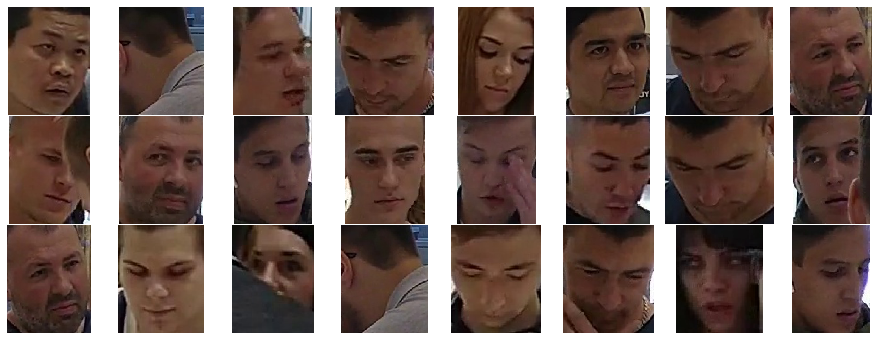

In [13]:
plot.show_images(juul_faces.image_paths, 3,8, fig_dims=(16,6))

##### Make predictions

In [21]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [17]:
BATCH_SIZE = 64
num_jobs = 4

In [18]:
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.45, 0.44, 0.49], [0.25, 0.22, 0.24]),
])

In [28]:
juul_faces = FaceDataset(juul_faces_detections, juul_faces_clusters, (224,224), 
                         input_transforms=img_transforms)

In [29]:
juul_loader = DataLoader(juul_faces, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_jobs)

In [32]:
for x,y in juul_loader: break

x.size(), x.mean()

(torch.Size([64, 3, 224, 224]), tensor(-0.9982))

In [110]:
age_predictions, gender_predictions = batch_cv_predictions(age_cv, gender_cv, juul_loader, BATCH_SIZE,
                                                           device)

Batches: 100%|██████████| 21/21 [03:13<00:00,  7.11s/it]


##### Decode predictions

In [24]:

predicted_ages = list(map(get_age_fn, age_predictions))

predicted_gender = list(map(get_gender_fn, gender_predictions))

In [31]:
image_paths = np.array(juul_faces.image_paths)
image_clusters = np.array(juul_faces.clusters)
predicted_ages = np.array(predicted_ages)
predicted_gender = np.array(predicted_gender)

##### Visualize predicted ages

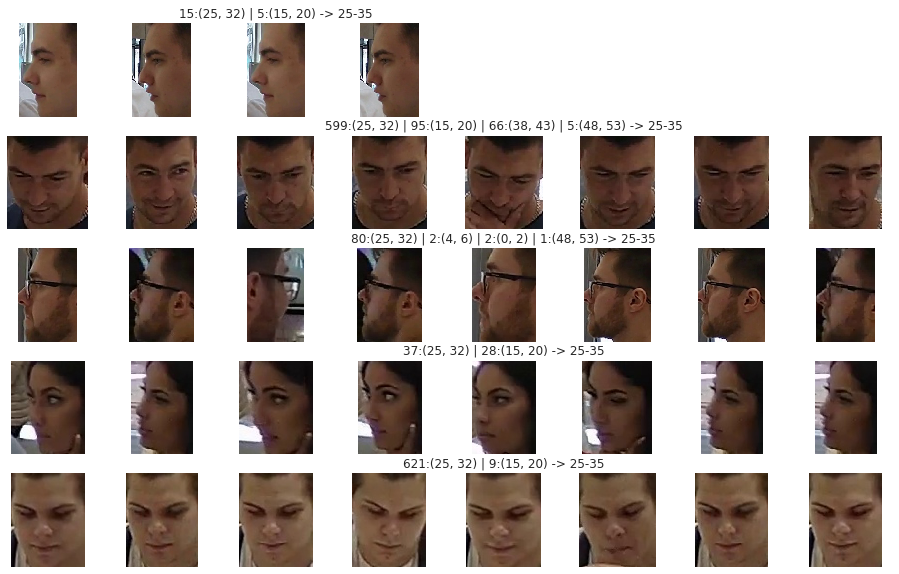

In [102]:
n_row, n_col = 5, 8

visalize_aggregated_cluster_prediction(n_row, n_col, image_clusters, image_paths, predicted_ages, 
                                       transform_age_label=True)

##### Visualize predicted Gender

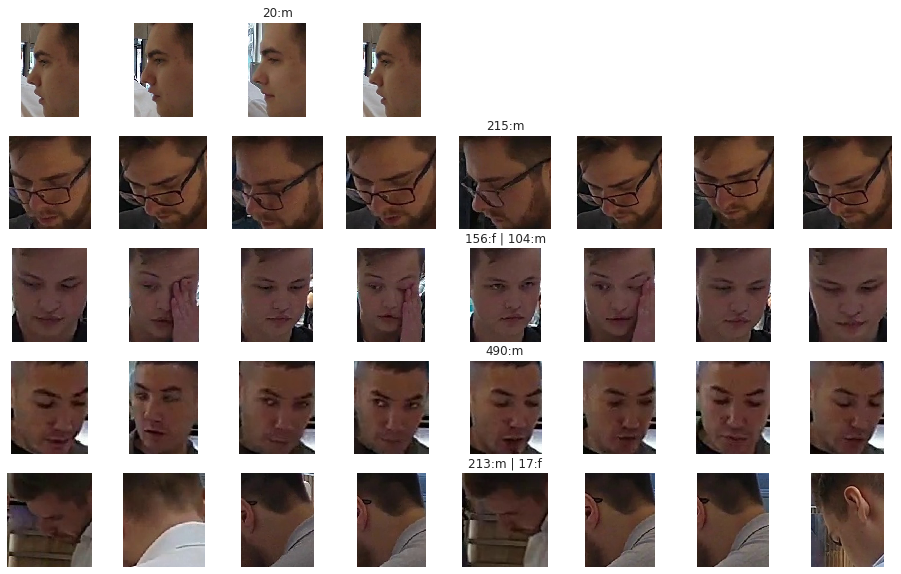

In [104]:
n_row, n_col = 5, 8

visalize_aggregated_cluster_prediction(n_row, n_col, image_clusters, image_paths, predicted_gender)

### Get cluster-wise predictions

In [130]:
import pandas as pd

In [132]:
predictions = pd.DataFrame({
                        'cluster': juul_faces.clusters,
                        'age': predicted_ages,
                        'gender': predicted_gender
                        })

In [133]:
predictions.head()

,cluster,age,gender
0,1.0,"{'(25, 32)': 5}",{'m': 5}
1,1.0,"{'(25, 32)': 5}",{'m': 5}
2,5.0,"{'(25, 32)': 5}",{'f': 5}
3,6.0,"{'(25, 32)': 5}",{'m': 5}
4,7.0,"{'(25, 32)': 5}",{'m': 5}


In [143]:
grouped['age_transformed'] = grouped['age'].apply(lambda x: transform_age(x))
grouped['gender_tranformed'] = grouped['gender'].apply(lambda x: transform_gender(x))

In [144]:
grouped.head()

,age,gender,age_transformed,gender_tranformed
cluster,,,,
1.0,"{'(25, 32)': 214, '(15, 20)': 1}",{'m': 215},25-35,m
4.0,"{'(25, 32)': 310, '(15, 20)': 47, '(38, 43)': ...",{'m': 370},25-35,m
5.0,"{'(25, 32)': 80, '(4, 6)': 2, '(0, 2)': 2, '(4...","{'f': 5, 'm': 80}",25-35,m
6.0,"{'(25, 32)': 410}",{'m': 410},25-35,m
7.0,"{'(25, 32)': 599, '(15, 20)': 95, '(38, 43)': ...",{'m': 765},25-35,m
